<a href="https://colab.research.google.com/github/vitroid/GenIce-core/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## for Google Colaboratory

In [30]:
%pip install git+https://github.com/vitroid/GenIce-core.git pairlist

  Cloning https://github.com/vitroid/GenIce-core.git to /tmp/pip-req-build-krkjg00d
  Running command git clone --filter=blob:none --quiet https://github.com/vitroid/GenIce-core.git /tmp/pip-req-build-krkjg00d
  Resolved https://github.com/vitroid/GenIce-core.git to commit eaa3e8de476705166e636319f4a66540df8bf310
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.9/685.9 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for genice2: filename=GenIce2-2.1.7.1-py2.py3-none-any.whl size=813961 sha256=81b53d445238b16b0091a2538c4695f44ea37f1f7bd0a07c5a119825855bb74b
  Stored in directory: /root/.cache/pip/wheels/ab/d

## 1. Make an arbitrary graph directed.

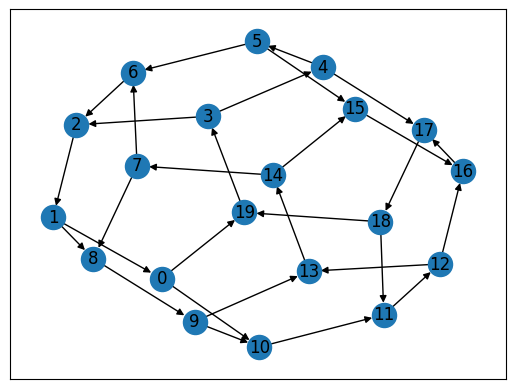

In [1]:
import networkx as nx
import matplotlib
import genice_core

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

# set orientations of the hydrogen bonds.
dg = genice_core.ice_graph(g)

nx.draw_networkx(dg, pos)

## 2. And depolarized.

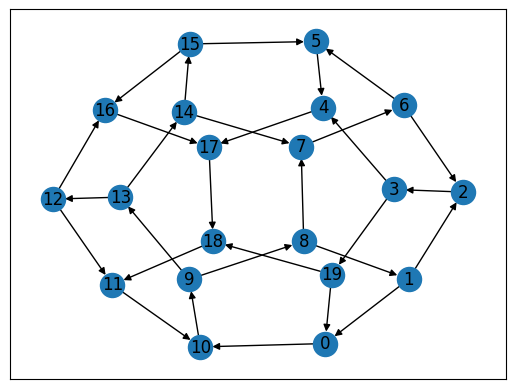

In [2]:
import networkx as nx
import matplotlib
import genice_core
from logging import getLogger, DEBUG, basicConfig, INFO

basicConfig(level=INFO)

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

# set orientations of the hydrogen bonds.
# Minimize the net dipole moment.
dg = genice_core.ice_graph(g, pos, dipoleOptimizationCycles=100)

nx.draw_networkx(dg, pos)

## 3. Under the periodic boundary condition.

In [5]:
from logging import DEBUG, INFO, basicConfig, getLogger

import networkx as nx
import numpy as np

# import py3Dmol
import pairlist
from genice_core import ice_graph

logger = getLogger()
basicConfig(level=INFO)

# a sample structure of ice 1h.
# The first line specifies the cell dimension, and atomic positions (absolute) follows.
pos = np.loadtxt("ice1h.txt").reshape(-1, 3)
cell, coords = pos[0], pos[1:]

# prepare the cell matrix
cellmat = np.diag(cell)

# make the fractional coordinates
fracCoords = coords / cell

# make a graph from the proximity
g = nx.Graph([(i, j) for i, j, _ in pairlist.pairs_iter(fracCoords, 0.3, cellmat)])

# set orientations of the hydrogen bonds.
dg = ice_graph(
    g, vertexPositions=fracCoords, isPeriodicBoundary=True, dipoleOptimizationCycles=100
)
dg

## Benchmark tests

### Scalability

In [13]:
import numpy as np

def diamond(N: int) -> np.ndarray:
    """Diamond lattice. == ice 1c

    Args:
        N (int): Number of unit cells per an edge of the simulation cell.

    Returns:
        np.ndarray: atomic positions in the fractional coordinate.
    """
    # make an FCC
    xyz = (
        np.array(
            [
                (x, y, z)
                for x in range(N)
                for y in range(N)
                for z in range(N)
                if (x + y + z) % 2 == 0
            ]
        )
        * 2
    )
    xyz = np.vstack([xyz, xyz + 1])
    return xyz / (2*N)


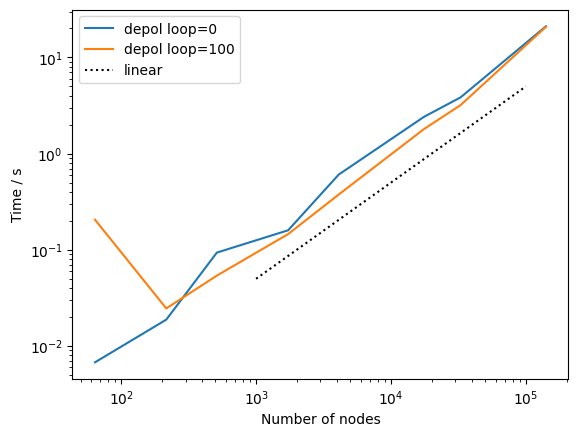

In [29]:
import pairlist as pl
import networkx as nx
import genice_core
import time
import matplotlib.pyplot as plt

np.random.seed(999)

for depol in (0, 100):
    X = []
    Y = []
    for N in (4,6,8,12,16,26,32,52):
        pos = diamond(N)
        cell = np.diag([N,N,N])
        # adjacency graph
        g = nx.Graph(
            [
                (i, j)
                for i, j in pl.pairs_iter(pos, 1, cell, fractional=True, distance=False)
            ]
        )

        now = time.time()
        dg = genice_core.ice_graph(
            g,
            vertexPositions=pos,
            dipoleOptimizationCycles=depol,
        )
        X.append(len(g))
        Y.append(time.time() - now)

    plt.plot(X, Y, label=f"depol loop={depol}")

plt.xscale("log")
plt.yscale("log")
X = np.logspace(3,5,10)
Y = X / 20000
plt.plot(X, Y, "k:", label="linear")
plt.xlabel("Number of nodes")
plt.ylabel("Time / s")
plt.legend()


### Doped ice

Comparison with original GenIce 2.1 using Buch's algorithm.

In [41]:
%pip install git+https://github.com/vitroid/GenIce.git#2.1.7.1

  Cloning https://github.com/vitroid/GenIce.git to /tmp/pip-req-build-n_ik_2bt
  Running command git clone --filter=blob:none --quiet https://github.com/vitroid/GenIce.git /tmp/pip-req-build-n_ik_2bt
  Resolved https://github.com/vitroid/GenIce.git to commit 3caa76fc76b6e2495ad8a41ed6eecf65b11035b3
  Preparing metadata (setup.py) ... done
  Created wheel for GenIce2: filename=GenIce2-2.1.7.1-py2.py3-none-any.whl size=813941 sha256=a53382dc5da0a9e7a1e5c8012b7b339f74579ed1ef4f836b1f88cfe764fbe925
  Stored in directory: /tmp/pip-ephem-wheel-cache-fgj29rwp/wheels/e3/cd/e5/c01a1e289ed91b3450961537712f27e418a19e77cc4b308144
Successfully built GenIce2
  Attempting uninstall: GenIce2
    Found existing installation: GenIce2 2.2
    Uninstalling GenIce2-2.2:
      Successfully uninstalled GenIce2-2.2


In [42]:
! time genice2 1c -r 24 24 24 --cation 0=Li --anion 10=F --depol=optimal > doped1c.gro

INFO ['10=F']
INFO __init__: Constructor of GenIce.
INFO   
INFO   Command line: /usr/local/bin/genice2 1c -r 24 24 24 --cation 0=Li --anion 10=F --depol=optimal
INFO No rotmatrices in lattice
INFO Cell dimension:
INFO   a = 4.0
INFO   b = 4.0
INFO   c = 4.0
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Bond length (specified): 1.9
INFO Target Density: 0.92
INFO Original Density: 0.0037363002324809044
INFO Bond length (scaled, nm): 0.3031365108343017
INFO __init__: end.
INFO __init__: 10 ms
INFO Stage1: Replicate water molecules to make a repeated cell.
INFO   Number of water molecules: 110592
INFO   Number of water nodes: 8
INFO Cell dimension:
INFO   a = 0.6381821280722142
INFO   b = 0.6381821280722142
INFO   c = 0.6381821280722142
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Stage1: end.
INFO Stage1: 75 ms
INFO Stage2: Make a random graph and replicate.
INFO replicate_graph: 2085 ms
INFO   Anionize: {10: 'F'}.
INFO   Cationize: {0: 'Li'}.
INFO Stage2: end.
INFO Stage2

In [43]:
! pip install git+https://github.com/vitroid/GenIce.git@genice-core

  Cloning https://github.com/vitroid/GenIce.git (to revision genice-core) to /tmp/pip-req-build-mj1821vb
  Running command git clone --filter=blob:none --quiet https://github.com/vitroid/GenIce.git /tmp/pip-req-build-mj1821vb
  Running command git checkout -b genice-core --track origin/genice-core
  Switched to a new branch 'genice-core'
  Branch 'genice-core' set up to track remote branch 'genice-core' from 'origin'.
  Resolved https://github.com/vitroid/GenIce.git to commit e65dba2ad3da977251f1418a3867dab01c7ee483
  Preparing metadata (setup.py) ... done
  Created wheel for GenIce2: filename=GenIce2-2.2-py2.py3-none-any.whl size=806589 sha256=bcf2ac74fe2b6993a0f13584f46192aab517d865030ea7c1850692adaf1fdb33
  Stored in directory: /tmp/pip-ephem-wheel-cache-xgdx3y8_/wheels/c2/19/4a/e97b6a2f20014802f89cd3a20982b09b3d3d285c6238061a53
Successfully built GenIce2
  Attempting uninstall: GenIce2
    Found existing installation: GenIce2 2.1.7.1
    Uninstalling GenIce2-2.1.7.1:
      Successf

In [44]:
! time genice2 1c -r 24 24 24 --cation 0=Li --anion 10=F --depol=optimal > doped1c.gro

INFO ['10=F']
INFO __init__: Constructor of GenIce.
INFO   
INFO   Command line: /usr/local/bin/genice2 1c -r 24 24 24 --cation 0=Li --anion 10=F --depol=optimal
INFO Cell dimension:
INFO   a = 4.0
INFO   b = 4.0
INFO   c = 4.0
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Bond length (specified): 1.9
INFO Target Density: 0.92
INFO Original Density: 0.0037363002324809044
INFO Bond length (scaled, nm): 0.3031365108343017
INFO __init__: end.
INFO __init__: 6 ms
INFO Stage1: Replicate water molecules to make a repeated cell.
INFO   Number of water molecules: 110592
INFO NumExpr defaulting to 2 threads.
INFO   Number of water nodes: 8
INFO Cell dimension:
INFO   a = 0.6381821280722142
INFO   b = 0.6381821280722142
INFO   c = 0.6381821280722142
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Stage1: end.
INFO Stage1: 854 ms
INFO Stage2: Make a random graph and replicate.
INFO replicate_graph: 1053 ms
INFO   Anionize: {10: 'F'}.
INFO   Cationize: {0: 'Li'}.
INFO Stage2: end.
INFO

In [46]:
! pip install py3dmol

In [47]:
! time genice2 1c -r 4 4 4 --cation 0=Li --anion 10=F --depol=optimal > doped1c.gro

INFO ['10=F']
INFO __init__: Constructor of GenIce.
INFO   
INFO   Command line: /usr/local/bin/genice2 1c -r 4 4 4 --cation 0=Li --anion 10=F --depol=optimal
INFO Cell dimension:
INFO   a = 4.0
INFO   b = 4.0
INFO   c = 4.0
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Bond length (specified): 1.9
INFO Target Density: 0.92
INFO Original Density: 0.0037363002324809044
INFO Bond length (scaled, nm): 0.3031365108343017
INFO __init__: end.
INFO __init__: 1 ms
INFO Stage1: Replicate water molecules to make a repeated cell.
INFO   Number of water molecules: 512
INFO NumExpr defaulting to 2 threads.
INFO   Number of water nodes: 8
INFO Cell dimension:
INFO   a = 0.6381821280722142
INFO   b = 0.6381821280722142
INFO   c = 0.6381821280722142
INFO   A = 90.0
INFO   B = 90.0
INFO   C = 90.0
INFO Stage1: end.
INFO Stage1: 520 ms
INFO Stage2: Make a random graph and replicate.
INFO replicate_graph: 12 ms
INFO   Anionize: {10: 'F'}.
INFO   Cationize: {0: 'Li'}.
INFO Stage2: end.
INFO Stage2:

In [53]:
import py3Dmol

# show
view = py3Dmol.view()
view.addModel("doped1c.gro")
view.setStyle({'stick':{}})
view.addUnitCell()
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol